## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

D:\Tools\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
D:\Tools\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import Dropout

def build_mlp(input_shape, num_neurons, drp_ratio, output_units=10):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
# Hyper params setting
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
num_neurons_list = [[512, 256], [512, 256, 128], [512, 256, 128, 64]]
drp_ratio_list = [0.1, 0.2, 0.3]

In [18]:
results = {}

for num_neurons in num_neurons_list:
    for drp_ratio in drp_ratio_list:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Experiment with num_neuron: {num_neurons} and drop_ratio: {drp_ratio}")
        model = build_mlp(input_shape = x_train.shape[1:], num_neurons = num_neurons, drp_ratio = drp_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = f"{len(num_neurons)} hidden layers drop%: {drp_ratio}"
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with num_neuron: [512, 256] and drop_ratio: 0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_______

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.1206 - acc: 0.2225 - val_loss: 1.9159 - val_acc: 0.3231
Epoch 2/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.9289 - acc: 0.3045 - val_loss: 1.8243 - val_acc: 0.3595
Epoch 3/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.8561 - acc: 0.3372 - val_loss: 1.7634 - val_acc: 0.3873
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.8061 - acc: 0.3575 - val_loss: 1.7173 - val_acc: 0.3946
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.7716 - acc: 0.3689 - val_loss: 1.6829 - val_acc: 0.4121
Epoch 6/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.7377 - acc: 0.3804 - val_loss: 1.6521 - val_acc: 0.4197
Epoch 7/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.7140 - acc: 0.3923 - val_loss: 1.6283 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 192us/step - loss: 2.0893 - acc: 0.2350 - val_loss: 1.8890 - val_acc: 0.3334
Epoch 2/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.8801 - acc: 0.3297 - val_loss: 1.7811 - val_acc: 0.3748
Epoch 3/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.7974 - acc: 0.3604 - val_loss: 1.7144 - val_acc: 0.3985
Epoch 4/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7432 - acc: 0.3782 - val_loss: 1.6687 - val_acc: 0.4120
Epoch 5/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7005 - acc: 0.3949 - val_loss: 1.6249 - val_acc: 0.4278
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6662 - acc: 0.4085 - val_loss: 1.5942 - val_acc: 0.4406
Epoch 7/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6368 - acc: 0.4207 - val_loss: 1.5701 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.1575 - acc: 0.2037 - val_loss: 1.9597 - val_acc: 0.3098- loss: 2.1625 - acc: 0.
Epoch 2/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.9629 - acc: 0.2869 - val_loss: 1.8471 - val_acc: 0.3535
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.8780 - acc: 0.3244 - val_loss: 1.7744 - val_acc: 0.37518838 - acc: - ETA: 0s - loss: 1.8808 - acc:
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.8232 - acc: 0.3466 - val_loss: 1.7291 - val_acc: 0.3971
Epoch 5/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.7787 - acc: 0.3634 - val_loss: 1.6818 - val_acc: 0.4059
Epoch 6/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.7444 - acc: 0.3748 - val_loss: 1.6481 - val_acc: 0.4153
Epoch 7/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.2108 - acc: 0.1758 - val_loss: 2.0144 - val_acc: 0.2741
Epoch 2/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.0237 - acc: 0.2515 - val_loss: 1.8999 - val_acc: 0.3283
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.9414 - acc: 0.2903 - val_loss: 1.8296 - val_acc: 0.3537
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.8831 - acc: 0.3172 - val_loss: 1.7759 - val_acc: 0.3767
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.8432 - acc: 0.3352 - val_loss: 1.7314 - val_acc: 0.3869
Epoch 6/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.8087 - acc: 0.3485 - val_loss: 1.6995 - val_acc: 0.4023
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.7768 - acc: 0.3610 - val_loss: 1.6665 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.1875 - acc: 0.1837 - val_loss: 2.0043 - val_acc: 0.2862 loss
Epoch 2/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.9944 - acc: 0.2738 - val_loss: 1.8770 - val_acc: 0.3402
Epoch 3/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.9013 - acc: 0.3123 - val_loss: 1.7986 - val_acc: 0.3618
Epoch 4/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.8377 - acc: 0.3364 - val_loss: 1.7477 - val_acc: 0.3810
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.7867 - acc: 0.3585 - val_loss: 1.6905 - val_acc: 0.4024
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.7429 - acc: 0.3763 - val_loss: 1.6485 - val_acc: 0.4172
Epoch 7/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.7084 - acc: 0.3875 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 215us/step - loss: 2.2284 - acc: 0.1569 - val_loss: 2.0633 - val_acc: 0.2632
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 2.0669 - acc: 0.2271 - val_loss: 1.9437 - val_acc: 0.3133
Epoch 3/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.9850 - acc: 0.2643 - val_loss: 1.8695 - val_acc: 0.3393
Epoch 4/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.9266 - acc: 0.2921 - val_loss: 1.8166 - val_acc: 0.3536
Epoch 5/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.8856 - acc: 0.3099 - val_loss: 1.7677 - val_acc: 0.3699
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8440 - acc: 0.3292 - val_loss: 1.7321 - val_acc: 0.3878
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.8130 - acc: 0.3433 - val_loss: 1.7

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.2868 - acc: 0.1364 - val_loss: 2.1759 - val_acc: 0.2207
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.1632 - acc: 0.1887 - val_loss: 2.0394 - val_acc: 0.2816
Epoch 3/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.0686 - acc: 0.2273 - val_loss: 1.9484 - val_acc: 0.3167s: 2.0725 -
Epoch 4/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.0057 - acc: 0.2564 - val_loss: 1.8800 - val_acc: 0.3348
Epoch 5/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.9601 - acc: 0.2784 - val_loss: 1.8367 - val_acc: 0.3543
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.9216 - acc: 0.2958 - val_loss: 1.7921 - val_acc: 0.3684
Epoch 7/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.8948 - acc: 0.3080 - val_lo

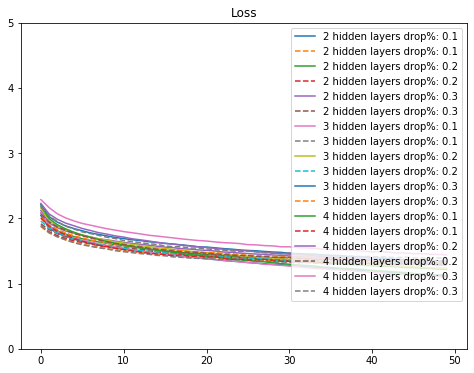

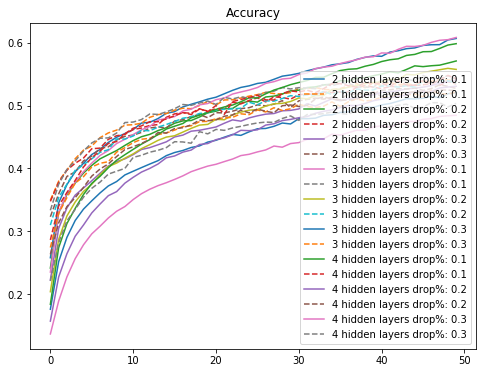

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()